*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Trusses

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/nullspace.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate, underride

## Section

In [3]:
# --- Imports ---
import pint
from sympy import symbols, Matrix, sqrt, simplify, Eq, solve

# --- Unit setup ---
ureg = pint.UnitRegistry()

# --- Symbolic variables (global scope) ---
L = symbols('L')
x_C, y_C = symbols('x_C y_C')
E_CA, E_CB = symbols('E_CA E_CB')
A_CA, A_CB = symbols('A_CA A_CB')
F = symbols('F')
u_x, u_y = symbols('u_x u_y')

# --- Position vectors of nodes ---
pos_A = Matrix([0, 0])
pos_B = Matrix([L, 0])
pos_C = Matrix([x_C, y_C])

# --- Displacement vector at node C ---
u_C = Matrix([u_x, u_y])
u_C

Matrix([
[u_x],
[u_y]])

In [4]:
# --- Vectors from node C to A and B ---
r_CA = pos_A - pos_C
r_CB = pos_B - pos_C

# --- Stiffnesses (scalar) ---
L_CA = r_CA.norm()
L_CB = r_CB.norm()

k_CA = E_CA * A_CA / L_CA
k_CB = E_CB * A_CB / L_CB
k_CA

A_CA*E_CA/sqrt(Abs(x_C)**2 + Abs(y_C)**2)

In [5]:
# --- Projector helper ---
def projector(r):
    rhat = r.normalized()
    return rhat * rhat.T

# --- Projection matrices ---
P_CA = projector(r_CA)
P_CB = projector(r_CB)

# Optional: display the matrices
print("P_CA (projection onto direction CA):")
display(P_CA)

print("P_CB (projection onto direction CB):")
display(P_CB)


P_CA (projection onto direction CA):


Matrix([
[ x_C**2/(Abs(x_C)**2 + Abs(y_C)**2), x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)],
[x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2),  y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)]])

P_CB (projection onto direction CB):


Matrix([
[  (L - x_C)**2/(Abs(y_C)**2 + Abs(L - x_C)**2), -y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)],
[-y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2),         y_C**2/(Abs(y_C)**2 + Abs(L - x_C)**2)]])

In [6]:
K = k_CA * P_CA + k_CB * P_CB
K

Matrix([
[  A_CA*E_CA*x_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*(L - x_C)**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2), A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)],
[A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2),         A_CA*E_CA*y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*y_C**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)]])

In [7]:
# External force vector
f_ext = Matrix([0, -F])

eq = sp.Eq(K * u_C, f_ext)
eq

Eq(Matrix([
[u_x*(A_CA*E_CA*x_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*(L - x_C)**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)) + u_y*(A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2))],
[      u_x*(A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)) + u_y*(A_CA*E_CA*y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*y_C**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2))]]), Matrix([
[ 0],
[-F]]))

In [8]:
# --- Numerical parameters (Pint quantities) ---
params = {
    'L': 15.0 * ureg.cm,
    'x_C': 15.0 / 2 * ureg.cm,
    'y_C': np.sqrt(3) * 15.0 / 2 * ureg.cm,
    'A_CA': 1.0 * ureg.cm * 0.2 * ureg.cm,
    'A_CB': 1.0 * ureg.cm * 0.2 * ureg.cm,
    'E_CA': 3.0e9 * ureg.Pa,
    'E_CB': 2.0e9 * ureg.Pa,
    'F': 9.8 * ureg.newton,
}

In [9]:
def make_subs(symbols, quantities):
    """Make a dictionary that maps from symbols to quantities.
    """
    return {sym: quantities[sym.name].to_base_units().magnitude for sym in symbols}

In [10]:
symbols_to_sub = [L, x_C, y_C, A_CA, A_CB, E_CA, E_CB, F]
subs = make_subs(symbols_to_sub, params)
subs

{L: 0.15,
 x_C: 0.075,
 y_C: np.float64(0.12990381056766578),
 A_CA: 2e-05,
 A_CB: 2e-05,
 E_CA: 3000000000.0,
 E_CB: 2000000000.0,
 F: 9.8}

In [11]:
def sympy_to_numpy(expr):
    """
    Substitute values into a SymPy expression or matrix and return a NumPy array of floats.

    Args:
        expr: A SymPy Matrix or expression.

    Returns:
        NumPy array with float dtype.
    """
    evaluated = expr.evalf()
    if isinstance(evaluated, sp.MatrixBase):
        return np.array(evaluated.tolist(), dtype=float)
    else:
        return float(evaluated)


K_np = sympy_to_numpy(K.subs(subs))
K_np

array([[166666.66666667,  57735.02691896],
       [ 57735.02691896, 500000.        ]])

Interpret the components.

In [12]:
u_example = np.array([7, -20]) * 1e-6
F_example = -K_np @ u_example
F_example

array([-0.01196613,  9.59585481])

So multiplying by K is a function that takes a displacement vector and returns a force vector.

In [13]:
eqs_num = eq.subs(subs)
eqs_num

Eq(Matrix([
[166666.666666667*u_x + 57735.0269189626*u_y],
[        57735.0269189626*u_x + 500000.0*u_y]]), Matrix([
[   0],
[-9.8]]))

In [14]:
sol = solve(eqs_num, (u_x, u_y))
sol

{u_x: 7.07254079757292e-6, u_y: -2.04166666666667e-5}

In [15]:
u_sol_np = np.array([sol[u_x], sol[u_y]], dtype=float)
u_sol_np

array([ 7.07254080e-06, -2.04166667e-05])

In [16]:
f_sol_np = K_np @ u_sol_np

In [17]:
u_example = u_sol_np

In [18]:
f_example = f_sol_np

## Draw the Force Field

In [19]:
scale = 1e-6
bound = 21
x_vals = np.linspace(-bound, bound, 11) * scale
y_vals = np.linspace(-bound, bound, 11) * scale
x_vals

array([-2.10e-05, -1.68e-05, -1.26e-05, -8.40e-06, -4.20e-06,  0.00e+00,
        4.20e-06,  8.40e-06,  1.26e-05,  1.68e-05,  2.10e-05])

In [20]:
pairs = [(x, y) for x in x_vals for y in y_vals]
U = np.array(pairs).T 
U.shape

(2, 121)

In [21]:
X, Y = np.meshgrid(x_vals, y_vals, indexing='ij')

In [22]:
X.shape

(11, 11)

In [23]:
X.ravel().shape

(121,)

In [24]:
U2 = np.vstack([X.ravel(), Y.ravel()])
np.allclose(U, U2)

True

Either way, U is matrix-like in the sense that it has two dimensions, but we are using it as a collection of vectors, so

In [25]:
F_field = -K_np @ U  # matrix of column force vectors
F_field.shape

(2, 121)

In [26]:
import matplotlib.lines as mlines

def outline_truss():

    # Get current axis
    ax = plt.gca()

    # Define endpoints of truss members (undisplaced)
    truss_left = np.array([-1, -1])   # lower left
    truss_right = np.array([1, -1])   # lower right
    joint = np.array([0, 0])          # shared node

    options = dict(
        linewidth=20,
        solid_capstyle='round',
        color='lightgray',
        alpha=0.5,
        transform=ax.transData
    )
    
    for start in [truss_left, truss_right]:
        line = mlines.Line2D([start[0], joint[0]], [start[1], joint[1]], **options)
        ax.add_artist(line)


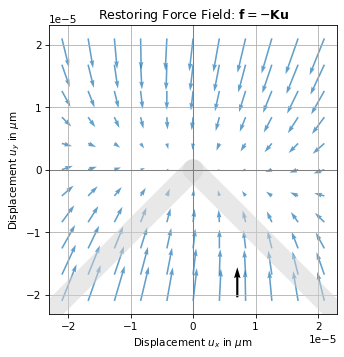

In [27]:
plt.figure(figsize=(5, 5))
outline_truss()

options = dict(angles='xy', scale_units='xy', scale=2e6)

plt.quiver(U[0], U[1], F_field[0], F_field[1], color='C0', alpha=0.7, **options)

plt.quiver(u_example[0], u_example[1], 
           F_example[0], F_example[1], lw=3,
           **options)

plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.gca().set_aspect('equal')

plt.xlabel('Displacement $u_x$ in $\mu$m')
plt.ylabel('Displacement $u_y$ in $\mu$m')
plt.title('Restoring Force Field: $\\mathbf{f} = -\\mathbf{K} \\mathbf{u}$')
plt.grid(True)
None

Discussion: This -- disappointingly -- is what a force field really is. Much less cool than we hoped. It's an example of a vector field, which is a mapping from each point in a space to a vector.



## Truss

In [28]:
def vec2(x, y):
    return sp.Matrix([x, y])

In [29]:
def add_n_triangle_truss(G, N, L, H, origin=vec2(0, 0)):
    """Add a row of N connected triangles to graph G.
    
    Nodes are named B0..BN (bottom) and T0..T{N-1} (top).
    """
    # Add bottom nodes and horizontal edges
    for i in range(N + 1):
        pos = origin + vec2(i * L, 0)
        G.add_node(f'B{i}', pos=pos)
        if i > 0:
            G.add_edge(f'B{i-1}', f'B{i}')
            
    # Identify the fixed points
    G.graph['fixed'] = ['B0', f'B{N}']

    # Add top nodes and diagonal edges
    for i in range(N):
        pos = origin + vec2((i + 0.5) * L, H)
        G.add_node(f'T{i}', pos=pos)
        G.add_edge(f'B{i}', f'T{i}')
        G.add_edge(f'T{i}', f'B{i+1}')

        if i > 0:
            G.add_edge(f'T{i-1}', f'T{i}')

In [30]:
G = nx.Graph()

N = 2
L = sp.Symbol('L', positive=True)
H = L * sp.sqrt(3) / 2
add_n_triangle_truss(G, N, L, H)

In [31]:
def setattr_node(G, node, **kwargs):
    """
    Set multiple attributes for a node in a NetworkX graph.

    Args:
        G: A NetworkX graph.
        node: Node identifier (usually a name).
        **kwargs: Arbitrary key-value pairs to set as node attributes.
    """
    G.nodes[node].update(**kwargs)


def getattr_node(G, node, *keys):
    """
    Get one or more attributes from a node in a NetworkX graph.

    Args:
        G: A NetworkX graph.
        node: Node identifier (usually a name).
        *keys: One or more attribute names.

    Returns:
        A single value if one key is provided, or a tuple of values if multiple.
    """
    if len(keys) == 1:
        return G.nodes[node][keys[0]]
    return tuple(G.nodes[node][key] for key in keys)


def setattr_edge(G, edge, **kwargs):
    """
    Set multiple attributes for an edge in a NetworkX graph.

    Args:
        G: A NetworkX graph.
        edge: A tuple of two node identifiers (e.g., ('A', 'B')).
        **kwargs: Arbitrary key-value pairs to set as edge attributes.
    """
    G.edges[edge].update(**kwargs)


def getattr_edge(G, edge, *keys):
    """
    Get one or more attributes from an edge in a NetworkX graph.

    Args:
        G: A NetworkX graph.
        edge: A tuple of two node identifiers.
        *keys: One or more attribute names.

    Returns:
        A single value if one key is provided, or a tuple of values if multiple.
    """
    if len(keys) == 1:
        return G.edges[edge][keys[0]]
    return tuple(G.edges[edge][key] for key in keys)

In [32]:
E, A = sp.symbols('E A')

for edge in G.edges:
    node1, node2 = edge
    x1 = G.nodes[node1]['pos']
    x2 = G.nodes[node2]['pos']

    r = x2 - x1
    l = r.norm()
    k = E * A / l

    setattr_edge(G, edge, E=E, A=A, r=r, l=l, k=k)

In [33]:
def draw_truss(G, subs, label_nodes=True, **options):
    pos = {}
    for node in G.nodes:
        p = getattr_node(G, node, 'pos').subs(subs).evalf()
        pos[node] = [float(x) for x in p]

    underride(options, edge_color='C0')
    nx.draw_networkx_edges(G, pos, width=2, **options)
    if label_nodes:
        node_options = dict(node_size=1000, node_color='white', edgecolors='C0')
        nx.draw_networkx_nodes(G, pos, **node_options)
        nx.draw_networkx_labels(G, pos, font_size=10)

    plt.axis('equal')
    plt.axis('off')

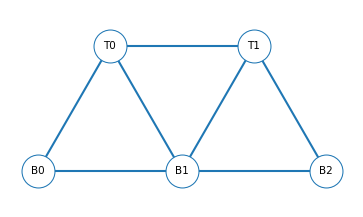

In [34]:
draw_truss(G, {L: 0.15})

Add displacement vectors to the nodes

In [35]:
def make_vector(x, y, **kwargs):
    return sp.ImmutableDenseMatrix([[x], [y]])

In [36]:
for node in G.nodes():
    if node in G.graph['fixed']:
        ux, uy = 0, 0
    else:
        ux, uy = sp.symbols(f'u_{node}_x u_{node}_y')
        
    disp = make_vector(ux, uy, name=f'u_{node}')
    setattr_node(G, node, disp=disp)

Assign an external force to each node.

In [37]:
z = make_vector(0, 0)
for i, node in enumerate(G.nodes):
    setattr_node(G, node, f_ext=z)

Hang a weight from the middle node.

In [38]:
f_ext = sp.Symbol('f_ext')
setattr_node(G, 'B1', f_ext=make_vector(0, f_ext))

In [39]:
for i, node in enumerate(G.nodes):
    setattr_node(G, node, index=i)

## Block Matrix Equation


In [40]:
def Ksym(i, j):
    return sp.MatrixSymbol(f'K_{i}{j}', 2, 2)

In [41]:
n = len(G.nodes)
K_blocks = [[Ksym(i, j) for j in range(n)] for i in range(n)]
K_block = sp.BlockMatrix(K_blocks)
K_block

Matrix([
[K_00, K_01, K_02, K_03, K_04],
[K_10, K_11, K_12, K_13, K_14],
[K_20, K_21, K_22, K_23, K_24],
[K_30, K_31, K_32, K_33, K_34],
[K_40, K_41, K_42, K_43, K_44]])

In [42]:
u_blocks = [sp.MatrixSymbol(f'u_{{{node}}}', 2, 1) for node in G.nodes]
u_vec = sp.BlockMatrix([[u] for u in u_blocks])
u_vec

Matrix([
[u_{B0}],
[u_{B1}],
[u_{B2}],
[u_{T0}],
[u_{T1}]])

In [43]:
f_blocks = [sp.MatrixSymbol(f'f_{{{node}}}', 2, 1) for node in G.nodes]
f_vec = sp.BlockMatrix([[f] for f in f_blocks])
f_vec

Matrix([
[f_{B0}],
[f_{B1}],
[f_{B2}],
[f_{T0}],
[f_{T1}]])

In [44]:
equation = sp.Eq(K_block * u_vec, f_vec)
equation

Eq(Matrix([
[K_00, K_01, K_02, K_03, K_04],
[K_10, K_11, K_12, K_13, K_14],
[K_20, K_21, K_22, K_23, K_24],
[K_30, K_31, K_32, K_33, K_34],
[K_40, K_41, K_42, K_43, K_44]])*Matrix([
[u_{B0}],
[u_{B1}],
[u_{B2}],
[u_{T0}],
[u_{T1}]]), Matrix([
[f_{B0}],
[f_{B1}],
[f_{B2}],
[f_{T0}],
[f_{T1}]]))

In an ideal world, we would write the equation this way and solve it, but we don't have solvers that can work on a system where the elements are vectors and matrices.


## Compute the Block Matrix

In [45]:
def edge_force_equation(G, edge):
    """
    Return the symbolic internal force vector on node i due to node j
    through the edge (i, j), using geometry and displacement attributes.
    """
    # Node data
    node1, node2 = edge
    u1 = getattr_node(G, node1, "disp")
    u2 = getattr_node(G, node2, "disp")

    # Edge properties
    r, k = getattr_edge(G, edge, "r", "k")

    # Geometry and stiffness    
    P = projector(r)

    # Internal force
    f_i = -k * P * (u1 - u2)

    return f_i

In [46]:
edge = 'B1', 'T0'
f = edge_force_equation(G, edge)
f

Matrix([
[-0.25*A*E*(u_B1_x - u_T0_x)/L + 0.25*sqrt(3)*A*E*(u_B1_y - u_T0_y)/L],
[ 0.25*sqrt(3)*A*E*(u_B1_x - u_T0_x)/L - 0.75*A*E*(u_B1_y - u_T0_y)/L]])

In [47]:
def compute_kP(G, edge):
    r, k = getattr_edge(G, edge, "r", "k")

    # Geometry and stiffness    
    P = projector(r)

    return k * P

In [48]:
def zero_block(size=2):
    return sp.ImmutableMatrix.zeros(size, size)

blocks = [[zero_block() for _ in range(n)] for _ in range(n)]

for edge in G.edges:
    kP = compute_kP(G, edge)
    
    a, b = edge
    i = getattr_node(G, a, 'index')
    j = getattr_node(G, b, 'index')

    # Insert contributions for edge (i, j)
    blocks[i][i] +=  kP
    blocks[i][j] += -kP
    blocks[j][i] += -kP
    blocks[j][j] +=  kP

In [49]:
keep = [getattr_node(G, node, 'index') 
        for node in G.nodes 
        if node not in G.graph['fixed']]
keep    

[1, 3, 4]

In [50]:
blocks_reduced = [
    [blocks[i][j] for j in keep]
    for i in keep
]

In [51]:
K_block = sp.BlockMatrix(blocks_reduced)
K_block

Matrix([
[                                        Matrix([
[2.5*A*E/L,         0],
[        0, 1.5*A*E/L]]), Matrix([
[       -0.25*A*E/L, 0.25*sqrt(3)*A*E/L],
[0.25*sqrt(3)*A*E/L,        -0.75*A*E/L]]), Matrix([
[        -0.25*A*E/L, -0.25*sqrt(3)*A*E/L],
[-0.25*sqrt(3)*A*E/L,         -0.75*A*E/L]])],
[    Matrix([
[       -0.25*A*E/L, 0.25*sqrt(3)*A*E/L],
[0.25*sqrt(3)*A*E/L,        -0.75*A*E/L]]),                                     Matrix([
[1.5*A*E/L,         0],
[        0, 1.5*A*E/L]]),                                                       Matrix([
[-1.0*A*E/L, 0],
[         0, 0]])],
[Matrix([
[        -0.25*A*E/L, -0.25*sqrt(3)*A*E/L],
[-0.25*sqrt(3)*A*E/L,         -0.75*A*E/L]]),                                                   Matrix([
[-1.0*A*E/L, 0],
[         0, 0]]),                                         Matrix([
[1.5*A*E/L,         0],
[        0, 1.5*A*E/L]])]])

In [52]:
u_blocks = [getattr_node(G, node, 'disp') for node in G.nodes]
u_blocks_reduced = [[u_blocks[i]] for i in keep]
u_block = sp.BlockMatrix(u_blocks_reduced)
u_block


Matrix([
[Matrix([
[u_B1_x],
[u_B1_y]])],
[Matrix([
[u_T0_x],
[u_T0_y]])],
[Matrix([
[u_T1_x],
[u_T1_y]])]])

In [53]:
f_blocks = [getattr_node(G, node, 'f_ext') for node in G.nodes]
f_blocks_reduced = [[f_blocks[i]] for i in keep]
f_block = sp.BlockMatrix(f_blocks_reduced)
f_block

Matrix([
[Matrix([
[    0],
[f_ext]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])]])

## Make the arrays explicit

In [54]:
K_dense = K_block.as_explicit()
K_dense

Matrix([
[          2.5*A*E/L,                   0,        -0.25*A*E/L, 0.25*sqrt(3)*A*E/L,         -0.25*A*E/L, -0.25*sqrt(3)*A*E/L],
[                  0,           1.5*A*E/L, 0.25*sqrt(3)*A*E/L,        -0.75*A*E/L, -0.25*sqrt(3)*A*E/L,         -0.75*A*E/L],
[        -0.25*A*E/L,  0.25*sqrt(3)*A*E/L,          1.5*A*E/L,                  0,          -1.0*A*E/L,                   0],
[ 0.25*sqrt(3)*A*E/L,         -0.75*A*E/L,                  0,          1.5*A*E/L,                   0,                   0],
[        -0.25*A*E/L, -0.25*sqrt(3)*A*E/L,         -1.0*A*E/L,                  0,           1.5*A*E/L,                   0],
[-0.25*sqrt(3)*A*E/L,         -0.75*A*E/L,                  0,                  0,                   0,           1.5*A*E/L]])

In [55]:
u_dense = u_block.as_explicit()

In [56]:
f_dense = f_block.as_explicit()

In [57]:
eq = Eq(K_dense * u_dense, f_dense)
eq

Eq(Matrix([
[2.5*A*E*u_B1_x/L - 0.25*A*E*u_T0_x/L + 0.25*sqrt(3)*A*E*u_T0_y/L - 0.25*A*E*u_T1_x/L - 0.25*sqrt(3)*A*E*u_T1_y/L],
[1.5*A*E*u_B1_y/L + 0.25*sqrt(3)*A*E*u_T0_x/L - 0.75*A*E*u_T0_y/L - 0.25*sqrt(3)*A*E*u_T1_x/L - 0.75*A*E*u_T1_y/L],
[                            -0.25*A*E*u_B1_x/L + 0.25*sqrt(3)*A*E*u_B1_y/L + 1.5*A*E*u_T0_x/L - 1.0*A*E*u_T1_x/L],
[                                                0.25*sqrt(3)*A*E*u_B1_x/L - 0.75*A*E*u_B1_y/L + 1.5*A*E*u_T0_y/L],
[                            -0.25*A*E*u_B1_x/L - 0.25*sqrt(3)*A*E*u_B1_y/L - 1.0*A*E*u_T0_x/L + 1.5*A*E*u_T1_x/L],
[                                               -0.25*sqrt(3)*A*E*u_B1_x/L - 0.75*A*E*u_B1_y/L + 1.5*A*E*u_T1_y/L]]), Matrix([
[    0],
[f_ext],
[    0],
[    0],
[    0],
[    0]]))

In [58]:
# --- Numerical parameters (Pint quantities) ---
params = {
    'L': 15.0 * ureg.cm,
    'A': 1.0 * ureg.cm * 0.2 * ureg.cm,
    'E': 3.0e9 * ureg.Pa,
    'f_ext': -9.8 * ureg.newton,
}

symbols_to_sub = [L, A, E, f_ext]
subs = make_subs(symbols_to_sub, params)
subs

{L: 0.15, A: 2e-05, E: 3000000000.0, f_ext: -9.8}

In [59]:
eqs_num = eq.subs(subs)


In [60]:
sol = solve(eqs_num, u_dense)
sol

{u_B1_x: 0.0,
 u_B1_y: -4.08333333333333e-5,
 u_T0_x: 7.07254079757292e-6,
 u_T0_y: -2.04166666666667e-5,
 u_T1_x: -7.07254079757292e-6,
 u_T1_y: -2.04166666666667e-5}

In [61]:
G_disp = G.copy()
scale = 300

for node in G_disp.nodes:
    pos = getattr_node(G_disp, node, 'pos')
    u = getattr_node(G_disp, node, 'disp')
    u_eval = u.subs(sol).evalf() * scale
    pos_new = pos + u_eval
    setattr_node(G_disp, node, pos=pos_new)

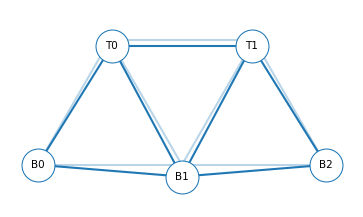

In [62]:
subs = {L: 0.15}
draw_truss(G, subs, label_nodes=False, alpha=0.3)
draw_truss(G_disp, subs)

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)